# Analysis of transaction lifecycle

<strong><font color="red">DRAFT: NEEDS QA REVIEW</font></strong>

*How long does it take, after a transaction is reaches the memory pool, for it to be reference by an RB?*

![Diagram of Leios pipeline stages](../tx-to-block-fig1.png)

![Description of Leios pipeline stages](../tx-to-block-fig2.png)

## Setup

### Language extensions

In [1]:
{-# LANGUAGE NamedFieldPuns #-}

### Import modules

In [2]:
--
-- ∆Q using Rationals
--
import DeltaQ

-- needed for visualisation within iHaskell
import Graphics.Rendering.Chart.Renderable

-- Other modules
import Data.Default (Default(..))
import Data.List (intercalate)
import Data.Ratio (approxRational, (%))
import Numeric.Function.Piecewise (evaluate)

-- useful for rendering Rationals with 'just enough' precision
asFloat :: Rational -> Float
asFloat = fromRational

### Utility functions

In [3]:
cumulativeSum :: Num a => [a] -> [a]
cumulativeSum = foldl (\acc x -> acc ++ [x + if null acc then 0 else last acc]) []

### Negative binomial distribution

We're only interested in the time to the first success, the random variable $\mathbf{S}$, so we have the following probability density and cumulative distribution, given a probability of $f$ for the event occuring in a time step.

$$
b(s, f) := \mathcal{P}[\mathbf{S} = s ] = \left( 1 - f \right) ^s \cdot f
$$

$$
B(s, f) := \mathcal{P}[\mathbf{S} \leq s] = \sum_{0 \leq t \leq s} \left( 1 - f \right) ^t \cdot f
$$


In [4]:
b :: Num a
  => Int
  -> a
  -> a
b s p = p * (1 - p)^s

In [5]:
bb :: Num a
   => Int
   -> a
   -> a
bb s p = sum [b s' p | s' <- [0..s]]

### Converting rate to probability

If $f$ is the rate of events per-trial (i.e., per-slot or per-stage), then $(1 - e^{-f})$ is the probability that at least on event will be observed in a given trial.

In [6]:
pFromRate :: Double
          -> Double
          -> Rational
pFromRate epsilon r = 1 - exp(- r) `approxRational` epsilon

## Scenario definition

In [7]:
data Scenario =
  MkScenario {
    nShard      :: Int     -- unitless
  , fIB         :: Double  -- IB/slot
  , fEB         :: Double  -- EB/stage
  , fRB         :: Double  -- RB/slot
  , stageLength :: Int     -- slot/stage
  , mu          :: Int     -- unitless
  , lambda      :: Int     -- unitless
  , epsilon     :: Double  -- unitless
  , duration    :: Int     -- slot
  }
  deriving Show

### Default scenario

In [8]:
instance Default Scenario where
  def =
    MkScenario
    {
      nShard = 1
    , fIB = 0.2
    , fEB = 1.5
    , fRB = 0.05
    , stageLength = 10
    , mu = 1
    , lambda = 1
    , epsilon = 1e-6
    , duration = 120
    }

### Example scenario

In [9]:
example :: Scenario
example =
  def {
    fIB = 0.2
  , fEB = 1.5
  , fRB = 0.05
  }

## Basics

### Slot progression

In [10]:
slots :: Int
      -> DQ
slots = wait . fromIntegral

### Stage progression

In [11]:
stages :: Scenario
       -> Int
       -> DQ
stages MkScenario{stageLength} count = wait . fromIntegral $ count * stageLength

### Waiting time

We could just do `choices` over a negative binomial distribution, but let's see how efficient the following approach is.

In [12]:
firstOccurrence :: Int -> Rational -> DQ
firstOccurrence 0 _ = never
firstOccurrence n p = choice p (wait 0) $ wait 1 .>>. firstOccurrence (n - 1) p

## Stages

### Transaction diffusion

We approximate transaction diffusion by the probability that the transaction has reached its destination in an integral number of slots.

In [13]:
tx :: DQ
tx = uniform 0 1 .>>. choices
       [
         (0.25, slots 1)
       , (0.50, slots 2)
       , (0.25, slots 3)
       ]

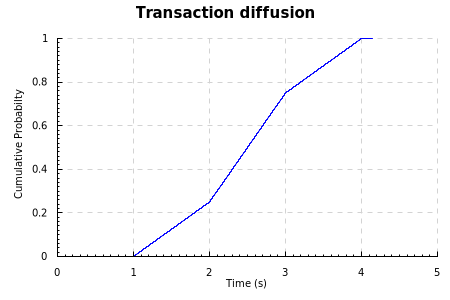

In [14]:
toRenderable $ plotCDF "Transaction diffusion" tx

### Stage 1. `Propose`

Once a transaction reaches the memory pool, it waits for an IB that matches its shard constraint.

- IB production rate: $f_\text{IB}$
- Number of shards: $n_\text{shard}$
- IB production rate per shard: $f^*_\text{IB} = f_\text{IB} / n_\text{shard}$
- IB shard probability: $f^\prime_\text{IB} = 1 - e^{- f_\text{IB} / n_\text{shard}}$
- Number of slots from submitting a transaction to having it appear in an IB: $\mathbf{S_1}$
- Probability density: $p_1(s_1) := \mathcal{P}[\mathbf{S_1} = s_1] = b(s_1, f^\prime_\text{IB})$

In [15]:
stage1 :: Scenario -> DQ
stage1 MkScenario{nShard, fIB, epsilon, duration} =
  firstOccurrence duration p
    where
      p = pFromRate epsilon $ fIB / fromIntegral nShard

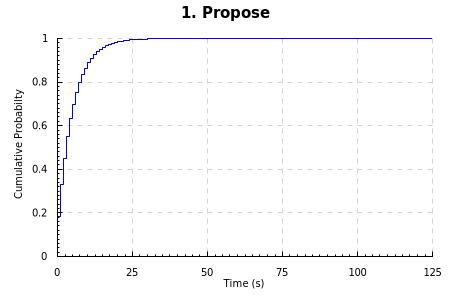

In [16]:
toRenderable $ plotCDF "1. Propose" $ stage1 example

In [17]:
txToStage1 :: Scenario -> DQ
txToStage1 scenario = tx .>>. stage1 scenario

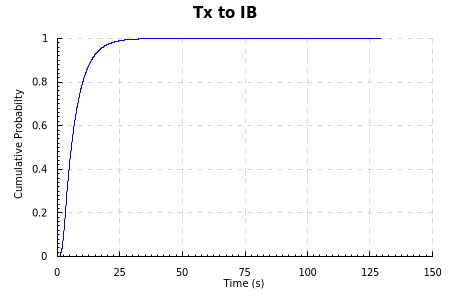

In [18]:
toRenderable $ plotCDF "Tx to IB" $ txToStage1 example

### Stage 2. `Deliver1`

The transaction reaches the beginning of `Deliver1` according to a truncated negative binomial distribution.

- Stage length: $L$
- Duration of `Deliver1` stage: $\mu L$
- Number of slots from when the IB was produced to the start of Delivery1: $\mathbf{S_2}$
- Probability density: $p_2(s_2) := \mathcal{P}[\mathbf{S_2} = s_2 \, | \, \mathbf{S_2} \leq L] = \left. b(L - s_2, f^\prime_\text{IB}) \middle/ B(L - 1, f^\prime_\text{IB}) \right.$

In [19]:
endOfStage1 :: Scenario -> DQ
endOfStage1 MkScenario{nShard, fIB, stageLength, epsilon} =
  choices [(num s / den, slots s) | s <- [1..stageLength]]
  where
    p = pFromRate epsilon $ fIB / fromIntegral nShard
    num s = b (stageLength - s) p
    den = bb (stageLength - 1) p  -- Not strictly necessary because `choices` uses relative probabilities.

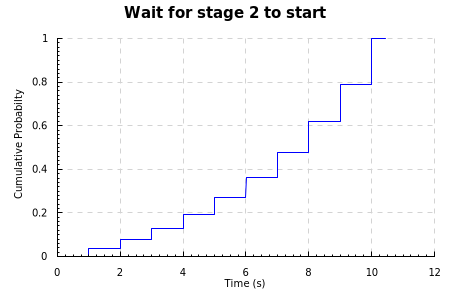

In [20]:
toRenderable $ plotCDF "Wait for stage 2 to start" $ endOfStage1 example

In [21]:
stage2 :: Scenario -> DQ
stage2 scenario@MkScenario{mu} = endOfStage1 scenario .>>. stages scenario mu

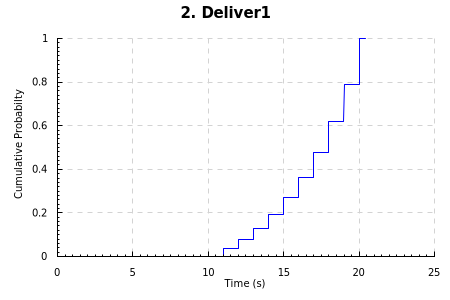

In [22]:
toRenderable $ plotCDF "2. Deliver1" $ stage2 example

In [23]:
txToStage2 :: Scenario -> DQ
txToStage2 scenario = txToStage1 scenario .>>. stage2 scenario

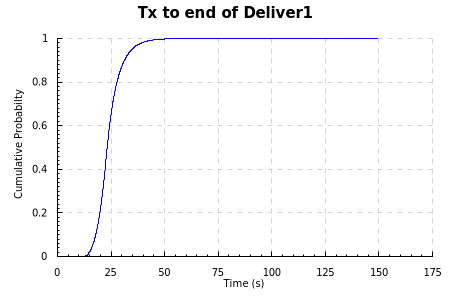

In [24]:
toRenderable $ plotCDF "Tx to end of Deliver1" $ txToStage2 example

### Stage 3. `Link`

If the IB is not included in an EB at the `Link` stage, it is orphaned forever.

- EB production rate: $f_\text{EB}$
- EB production probability: $f^\prime_\text{EB} = 1 - e^{- f_\text{EB}}$
- Whether the IB is linked to an EB: $\mathbf{S_3}$.
- Probability: $p_3(s_3) := \mathcal{P}[\mathbf{S_3} = s_3]$
    - $p_3(1) = f^\prime_\text{EB}$
    - $p_3(0) = 1 - f^\prime_\text{EB}$

In [25]:
stage3 :: Scenario -> DQ
stage3 scenario@MkScenario{fEB, epsilon} =
  choice p (stages scenario 1) never
    where p = pFromRate epsilon fEB

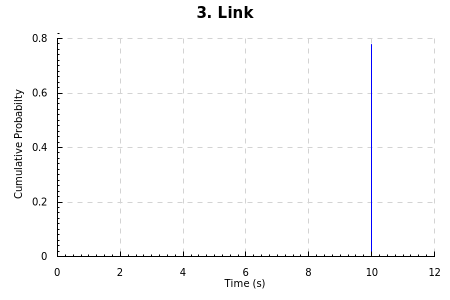

In [26]:
toRenderable $ plotCDF "3. Link" $ stage3 example

In [27]:
txToStage3 :: Scenario -> DQ
txToStage3 scenario = txToStage2 scenario .>>. stage3 scenario

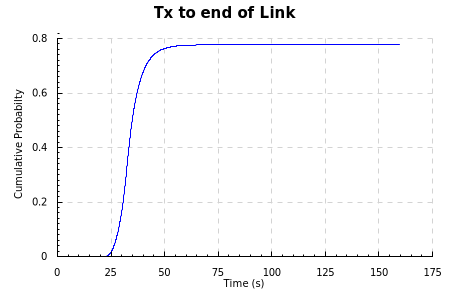

In [28]:
toRenderable $ plotCDF "Tx to end of Link" $ txToStage3 example

### Stage 4. `Deliver2`

The `Deliver2` stage lasts $\lambda L$ slots.

In [29]:
stage4 :: Scenario -> DQ
stage4 scenario@MkScenario{lambda} = stages scenario lambda

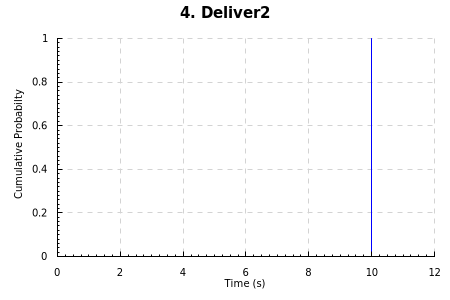

In [30]:
toRenderable $ plotCDF "4. Deliver2" $ stage4 example

In [31]:
txToStage4 :: Scenario -> DQ
txToStage4 scenario = txToStage3 scenario .>>. stage4 scenario

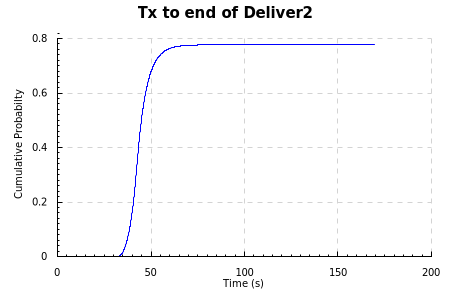

In [32]:
toRenderable $ plotCDF "Tx to end of Deliver2" $ txToStage4 example

### Stage 5. `Vote1`

The `Vote1` stage lasts $L$ slots.

In [33]:
stage5 :: Scenario -> DQ
stage5 scenario = stages scenario 1

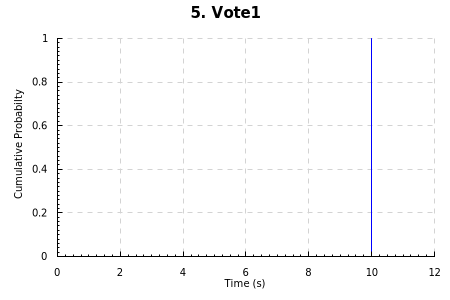

In [34]:
toRenderable $ plotCDF "5. Vote1" $ stage5 example

In [35]:
txToStage5 :: Scenario -> DQ
txToStage5 scenario = txToStage4 scenario .>>. stage5 scenario

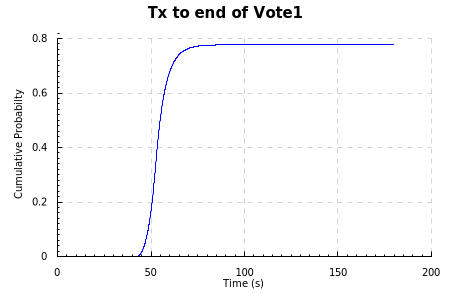

In [36]:
toRenderable $ plotCDF "Tx to end of Vote1" $ txToStage5 example

### Stage 6. `Endorse`

In Full Leios, the Vote1-certified EB waits for a pipeline where it is endorsed. If it is not endorsed in current pipeline, it has to skip one pipeline before it is included in a later endorsement stage.

- Number of stages before IB is endorsed: $\mathbf{S_6}$
- Probability: $p_6(s_6) := \mathcal{P}[\mathbf{S_6} = s_6]$
    - $p_6(0) = f^\prime_\text{EB}$
    - $p_6(1) = 0$
    - $p_6(s_6) = b(s_6 - 1, f^\prime_\text{EB})$, for $s > 1$

In [37]:
stage6 :: Scenario -> DQ
stage6 scenario@MkScenario{fEB, stageLength, duration, epsilon} =
  choices
    $ (1 - sum (fst <$> ps), never) : ps
    where
      p = pFromRate epsilon fEB
      ps = (p, stages scenario 1)
             : [(b (s - 1) p, stages scenario s) | s <- [2 .. duration `div` stageLength]]

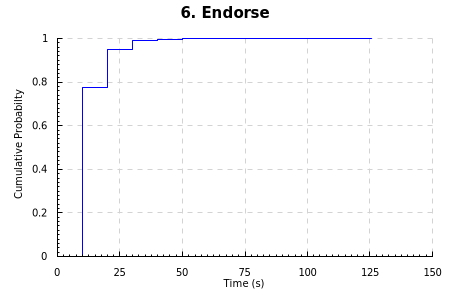

In [38]:
toRenderable $ plotCDF "6. Endorse" $ stage6 example

In [39]:
txToStage6 :: Scenario -> DQ
txToStage6 scenario = txToStage5 scenario .>>. stage6 scenario

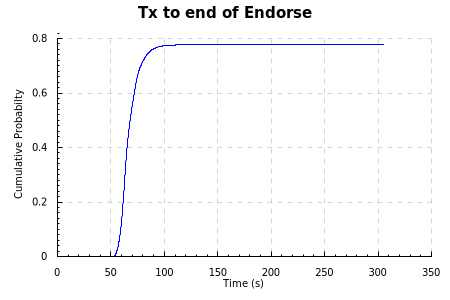

In [40]:
toRenderable $ plotCDF "Tx to end of Endorse" $ txToStage6 example

### Stage 7. `Vote2`

The `Vote2` stage lasts $L$ slots.

In [41]:
stage7 :: Scenario -> DQ
stage7 scenario = stages scenario 1

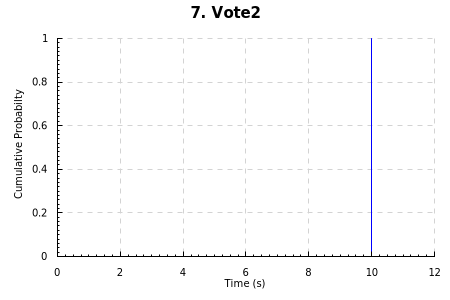

In [42]:
toRenderable $ plotCDF "7. Vote2" $ stage7 example

In [43]:
txToStage7 :: Scenario -> DQ
txToStage7 scenario = txToStage6 scenario .>>. stage7 scenario

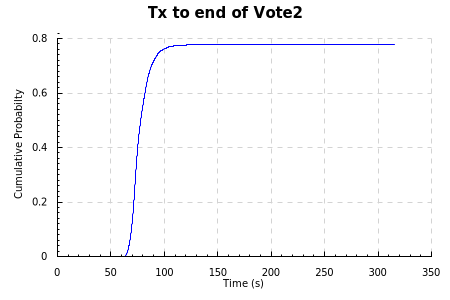

In [44]:
toRenderable $ plotCDF "Tx to end of Vote2" $ txToStage7 example

### Praos

Now wait for a Praos block.

- Active slot coefficient: $f_\text{RB} = 0.05$
- Number of slots to wait for inclusion in an RB: $\mathbf{S_\text{RB}}$
- Probability density: $p_\text{RB}(s_\text{RB}) := \mathcal{P}[\mathbf{S_\text{RB}} = s_\text{RB}] = b(s_\text{RB}, 1, f_\text{RB})$

In [45]:
praos :: Scenario -> DQ
praos MkScenario{fRB, duration, epsilon} =
  firstOccurrence duration p
    where p = pFromRate epsilon fRB

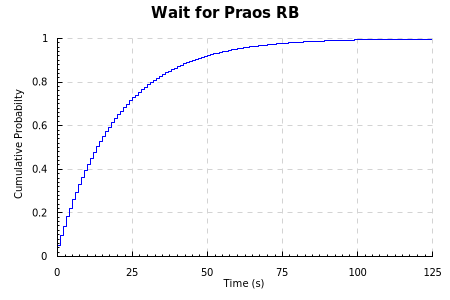

In [46]:
toRenderable $ plotCDF "Wait for Praos RB" $ praos example

In [47]:
txToRB :: Scenario -> DQ
txToRB scenario = txToStage7 scenario .>>. praos scenario

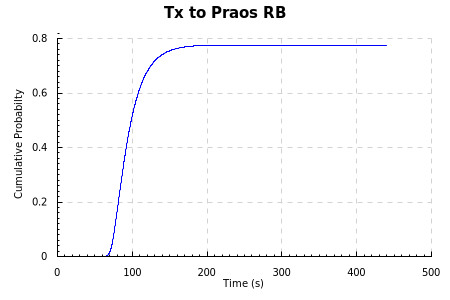

In [48]:
toRenderable $ plotCDF "Tx to Praos RB" $ txToRB example

## Evaluate a few points

In [49]:
approximate :: Fractional a => Scenario -> Rational -> a
approximate = ((fromRational .) . evaluate) . distribution . txToRB

In [50]:
example

MkScenario {nShard = 1, fIB = 0.2, fEB = 1.5, fRB = 5.0e-2, stageLength = 10, mu = 1, lambda = 1, epsilon = 1.0e-6, duration = 120}

In [51]:
putStrLn . unlines
  $ intercalate "\t"
  <$> [[show $ fromRational s, show $ approximate example s] | s <- [50,75..225]]

50.0	0.0
75.0	7.819751146301063e-2
100.0	0.5172618166905172
125.0	0.7006302107478529
150.0	0.7549803576197476
175.0	0.7705977924130235
200.0	0.7746467199096114
225.0	0.7749364027080629

Sadly ☹️, the table above disagrees somewhat with the computations done in R based on analytic expressions, so we need more QA on both approaches, but note that the two are formulated differently and that could explain the difference.

## Compare IB rates

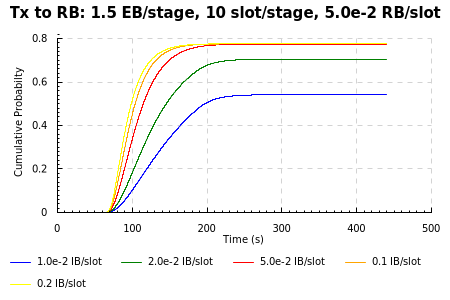

In [52]:
toRenderable
  $ plotCDFs
    ("Tx to RB: " <> show (fEB example) <> " EB/stage, " <> show (stageLength example) <> " slot/stage, " <> show (fRB example) <> " RB/slot")
  [
    (show fIB <> " IB/slot", txToRB $ example {fIB})
  |
    fIB <- [0.01, 0.02, 0.05, 0.10, 0.20]
  ]